## Font type Recognition using Logistic Regression


* <font size=4 color='green'>MSTC seminar on Deep Learning & Tensorflow</font>

In [11]:
import tensorflow as tf
import numpy as np

In [12]:
! pip install tqdm

  Using cached tqdm-4.11.2-py2.py3-none-any.whl


Exception:
Traceback (most recent call last):
  File "/Library/Python/2.7/site-packages/pip-9.0.1-py2.7.egg/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/Library/Python/2.7/site-packages/pip-9.0.1-py2.7.egg/pip/commands/install.py", line 342, in run
    prefix=options.prefix_path,
  File "/Library/Python/2.7/site-packages/pip-9.0.1-py2.7.egg/pip/req/req_set.py", line 784, in install
    **kwargs
  File "/Library/Python/2.7/site-packages/pip-9.0.1-py2.7.egg/pip/req/req_install.py", line 851, in install
    self.move_wheel_files(self.source_dir, root=root, prefix=prefix)
  File "/Library/Python/2.7/site-packages/pip-9.0.1-py2.7.egg/pip/req/req_install.py", line 1064, in move_wheel_files
    isolated=self.isolated,
  File "/Library/Python/2.7/site-packages/pip-9.0.1-py2.7.egg/pip/wheel.py", line 345, in move_wheel_files
    clobber(source, lib_dir, True)
  File "/Library/Python/2.7/site-packages/pip-9.0.1-py2.7.egg/pip/wheel.py", line 316, in clobber

In [13]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

In [14]:
"""
Load and data
"""

import os
from six.moves import urllib

file_url = 'https://github.com/bloolizard/PlayWithTensorFlow/raw/master/data_with_labels.npz'
file_name = 'data_with_labels.npz'

if not os.path.exists(file_name):
    urllib.request.urlretrieve(file_url, file_name)

In [15]:
os.listdir("./")

['.git',
 '.gitignore',
 '.idea',
 '.ipynb_checkpoints',
 '.python-version',
 'data_with_labels.npz',
 'MSTC_FontReco_CNN.ipynb',
 'MSTC_FontReco_FeedForward.ipynb',
 'MSTC_FontReco_LogisticReg.ipynb',
 'MSTC_Intro_DNN_1.pdf',
 'MSTC_Intro_DNN_2.pdf',
 'MSTC_Intro_DNN_3.pdf',
 'MSTC_IntroTF_1.ipynb',
 'MSTC_IntroTF_2.ipynb',
 'MSTC_RNN_1.ipynb',
 'MSTC_RNN_2_dynamic.ipynb',
 'MSTC_RNN_3.ipynb',
 'README.md',
 'requirements.txt',
 'Tensorflow_0_10_0.ipynb']

In [16]:
#os.remove("./D:\\MLmaster\\Tree.dot")

In [17]:
# Load data
data = np.load('data_with_labels.npz')

train = data['arr_0']/255.
labels = data['arr_1']

### Data: 2790 36x36 images

In [18]:
train.shape

(2790, 36, 36)

In [19]:
# Look at some data
print(train[1])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [20]:
# If you have matplotlib installed
import matplotlib.pyplot as plt
%matplotlib inline

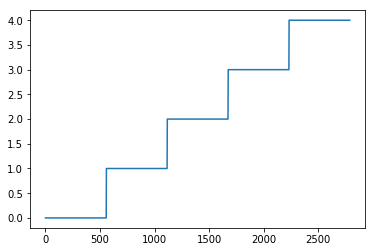

In [21]:
plt.plot(labels)

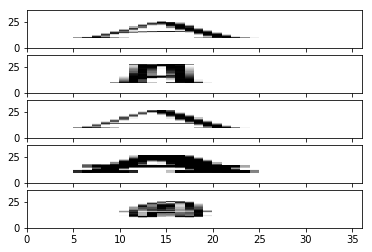

In [22]:
plt.ion()

# Let's look at a subplot of one of A in each font
f, plts = plt.subplots(5, sharex=True)
c = 90
for i in range(5):
    plts[i].pcolor(train[c + i * 558],
                   cmap=plt.cm.gray_r)

In [23]:
def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

In [24]:
print(onehot[600])

[ 0.  1.  0.  0.  0.]


### Permutation! + split data into training / validation

In [15]:
# Split data into training (90%) and validation (10%)
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
test, train = train[test_idx,:],\
              train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]

In [16]:
test.shape

(279, 36, 36)

In [17]:
onehot_test[0:4]

array([[ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.]])

In [18]:
36*36

1296

In [29]:
sess = tf.InteractiveSession()


# These will be inputs
# Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
# Known labels
y_ = tf.placeholder("float", [None, 5])

# Variables
W = tf.Variable(tf.zeros([1296,5]))
b = tf.Variable(tf.zeros([5]))

# Just initialize
sess.run(tf.initialize_all_variables())
# sess.run(tf.global_variables_initializer())

# Define model
# y = tf.nn.softmax(tf.matmul(x,W)
y = tf.matmul(x, W) + b

# End model specification, begin training code


# Climb on cross-entropy - don't apply twice the softmax 
# function (normalization) function because some funny things happen with TF.
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
        y + 1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [30]:
# Actually train
epochs = 1000

# aux arrays to store train and test accuracy results
# once every 10 epochs

train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)

for i in tqdm(range(epochs)):
    # Record summary data, and the accuracy
    if i % 10 == 0:
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={
            x: train.reshape([-1,1296]),
            y_: onehot_train})
        train_acc[i//10] = A
        # And now the validation set
        A = accuracy.eval(feed_dict={
            x: test.reshape([-1,1296]),
            y_: onehot_test})
        test_acc[i//10] = A
        
    # ALL data is used in every run (i.e. no minibatches)    
    train_step.run(feed_dict={
        x: train.reshape([-1,1296]),
        y_: onehot_train})

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<02:27,  6.76it/s]

  1%|          | 6/1000 [00:00<01:49,  9.09it/s]

  1%|          | 10/1000 [00:00<01:25, 11.55it/s]

  1%|▏         | 13/1000 [00:00<01:10, 13.98it/s]

  2%|▏         | 16/1000 [00:00<00:59, 16.55it/s]

  2%|▏         | 21/1000 [00:00<00:48, 20.17it/s]

  2%|▎         | 25/1000 [00:00<00:41, 23.48it/s]

  3%|▎         | 30/1000 [00:00<00:35, 27.34it/s]

  4%|▎         | 35/1000 [00:01<00:30, 31.39it/s]

  4%|▍         | 41/1000 [00:01<00:27, 35.21it/s]

  5%|▍         | 47/1000 [00:01<00:24, 39.37it/s]

  5%|▌         | 52/1000 [00:01<00:26, 35.28it/s]

  6%|▌         | 57/1000 [00:01<00:28, 32.75it/s]

  6%|▌         | 61/1000 [00:01<00:30, 30.52it/s]

  6%|▋         | 65/1000 [00:01<00:32, 28.41it/s]

  7%|▋         | 69/1000 [00:02<00:32, 28.69it/s]

  7%|▋         | 73/1000 [00:02<00:33, 27.68it/s]

  8%|▊         | 78/1000 [00:02<00:29, 31.75it/s]

  8%|▊         | 83/1000 [00:02<00:25, 35.61it/s]

  9%|▉         | 89/1000 [00:02<00:22, 40.01it/s]

  9%|▉         | 94/1000 [00:02<00:21, 41.68it/s]

 10%|█         | 100/1000 [00:02<00:20, 44.73it/s]

 10%|█         | 105/1000 [00:02<00:19, 45.28it/s]

 11%|█         | 111/1000 [00:02<00:19, 45.97it/s]

 12%|█▏        | 117/1000 [00:03<00:18, 47.85it/s]

 12%|█▏        | 122/1000 [00:03<00:18, 46.34it/s]

 13%|█▎        | 127/1000 [00:03<00:22, 38.04it/s]

 13%|█▎        | 132/1000 [00:03<00:23, 36.88it/s]

 14%|█▎        | 136/1000 [00:03<00:26, 32.31it/s]

 14%|█▍        | 140/1000 [00:03<00:28, 30.30it/s]

 14%|█▍        | 144/1000 [00:04<00:32, 26.45it/s]

 15%|█▍        | 148/1000 [00:04<00:29, 28.67it/s]

 15%|█▌        | 152/1000 [00:04<00:33, 25.07it/s]

 16%|█▌        | 155/1000 [00:04<00:34, 24.80it/s]

 16%|█▌        | 158/1000 [00:04<00:33, 25.21it/s]

 16%|█▌        | 161/1000 [00:04<00:36, 23.22it/s]

 16%|█▋        | 164/1000 [00:04<00:34, 24.10it/s]

 17%|█▋        | 170/1000 [00:04<00:28, 29.07it/s]

 18%|█▊        | 175/1000 [00:05<00:25, 32.95it/s]

 18%|█▊        | 181/1000 [00:05<00:22, 36.61it/s]

 19%|█▊        | 186/1000 [00:05<00:20, 39.47it/s]

 19%|█▉        | 191/1000 [00:05<00:19, 41.10it/s]

 20%|█▉        | 197/1000 [00:05<00:17, 44.87it/s]

 20%|██        | 202/1000 [00:05<00:17, 45.35it/s]

 21%|██        | 208/1000 [00:05<00:16, 48.37it/s]

 21%|██▏       | 214/1000 [00:05<00:16, 48.83it/s]

 22%|██▏       | 220/1000 [00:06<00:17, 43.73it/s]

 23%|██▎       | 226/1000 [00:06<00:16, 45.97it/s]

 23%|██▎       | 231/1000 [00:06<00:16, 46.59it/s]

 24%|██▎       | 236/1000 [00:06<00:16, 45.82it/s]

 24%|██▍       | 241/1000 [00:06<00:16, 46.33it/s]

 25%|██▍       | 247/1000 [00:06<00:15, 48.66it/s]

 25%|██▌       | 252/1000 [00:06<00:15, 48.68it/s]

 26%|██▌       | 258/1000 [00:06<00:14, 50.32it/s]

 26%|██▋       | 264/1000 [00:06<00:14, 49.63it/s]

 27%|██▋       | 270/1000 [00:07<00:14, 51.61it/s]

 28%|██▊       | 276/1000 [00:07<00:14, 50.97it/s]

 28%|██▊       | 282/1000 [00:07<00:14, 50.47it/s]

 29%|██▉       | 288/1000 [00:07<00:16, 44.35it/s]

 29%|██▉       | 293/1000 [00:07<00:19, 36.77it/s]

 30%|██▉       | 297/1000 [00:07<00:20, 33.52it/s]

 30%|███       | 301/1000 [00:07<00:24, 28.58it/s]

 30%|███       | 305/1000 [00:08<00:25, 27.44it/s]

 31%|███       | 308/1000 [00:08<00:25, 26.82it/s]

 31%|███       | 311/1000 [00:08<00:28, 24.52it/s]

 32%|███▏      | 317/1000 [00:08<00:23, 29.22it/s]

 32%|███▏      | 322/1000 [00:08<00:20, 32.75it/s]

 33%|███▎      | 328/1000 [00:08<00:17, 37.49it/s]

 33%|███▎      | 333/1000 [00:08<00:16, 40.33it/s]

 34%|███▍      | 338/1000 [00:08<00:15, 42.45it/s]

 34%|███▍      | 343/1000 [00:09<00:14, 44.10it/s]

 35%|███▍      | 349/1000 [00:09<00:13, 47.40it/s]

 35%|███▌      | 354/1000 [00:09<00:13, 47.01it/s]

 36%|███▌      | 359/1000 [00:09<00:13, 46.09it/s]

 36%|███▋      | 364/1000 [00:09<00:16, 39.38it/s]

 37%|███▋      | 370/1000 [00:09<00:14, 43.38it/s]

 38%|███▊      | 376/1000 [00:09<00:13, 45.78it/s]

 38%|███▊      | 381/1000 [00:09<00:13, 46.15it/s]

 39%|███▊      | 387/1000 [00:09<00:12, 47.81it/s]

 39%|███▉      | 392/1000 [00:10<00:12, 47.94it/s]

 40%|███▉      | 398/1000 [00:10<00:12, 49.65it/s]

 40%|████      | 404/1000 [00:10<00:12, 48.82it/s]

 41%|████      | 410/1000 [00:10<00:11, 49.86it/s]

 42%|████▏     | 416/1000 [00:10<00:11, 50.48it/s]

 42%|████▏     | 422/1000 [00:10<00:11, 50.49it/s]

 43%|████▎     | 428/1000 [00:10<00:10, 52.53it/s]

 43%|████▎     | 434/1000 [00:10<00:10, 51.67it/s]

 44%|████▍     | 440/1000 [00:10<00:10, 52.68it/s]

 45%|████▍     | 446/1000 [00:11<00:10, 52.44it/s]

 45%|████▌     | 452/1000 [00:11<00:10, 51.62it/s]

 46%|████▌     | 458/1000 [00:11<00:10, 50.48it/s]

 46%|████▋     | 464/1000 [00:11<00:10, 49.95it/s]

 47%|████▋     | 470/1000 [00:11<00:10, 51.26it/s]

 48%|████▊     | 476/1000 [00:11<00:10, 51.04it/s]

 48%|████▊     | 482/1000 [00:11<00:10, 49.14it/s]

 49%|████▊     | 487/1000 [00:11<00:10, 47.47it/s]

 49%|████▉     | 492/1000 [00:12<00:10, 47.50it/s]

 50%|████▉     | 498/1000 [00:12<00:10, 49.37it/s]

 50%|█████     | 503/1000 [00:12<00:10, 47.99it/s]

 51%|█████     | 508/1000 [00:12<00:10, 45.51it/s]

 51%|█████▏    | 513/1000 [00:12<00:10, 45.69it/s]

 52%|█████▏    | 519/1000 [00:12<00:10, 48.06it/s]

 52%|█████▏    | 524/1000 [00:12<00:09, 48.06it/s]

 53%|█████▎    | 530/1000 [00:12<00:09, 49.89it/s]

 54%|█████▎    | 536/1000 [00:12<00:09, 49.71it/s]

 54%|█████▍    | 542/1000 [00:13<00:09, 49.48it/s]

 55%|█████▍    | 548/1000 [00:13<00:08, 50.62it/s]

 55%|█████▌    | 554/1000 [00:13<00:09, 48.36it/s]

 56%|█████▌    | 559/1000 [00:13<00:09, 48.58it/s]

 56%|█████▋    | 564/1000 [00:13<00:09, 48.44it/s]

 57%|█████▋    | 570/1000 [00:13<00:08, 49.77it/s]

 57%|█████▊    | 575/1000 [00:13<00:08, 49.08it/s]

 58%|█████▊    | 581/1000 [00:13<00:08, 48.51it/s]

 59%|█████▊    | 587/1000 [00:13<00:08, 50.07it/s]

 59%|█████▉    | 593/1000 [00:14<00:08, 49.99it/s]

 60%|█████▉    | 599/1000 [00:14<00:07, 50.65it/s]

 60%|██████    | 605/1000 [00:14<00:08, 47.33it/s]

 61%|██████    | 611/1000 [00:14<00:08, 47.83it/s]

 62%|██████▏   | 617/1000 [00:14<00:07, 49.27it/s]

 62%|██████▏   | 622/1000 [00:14<00:07, 47.51it/s]

 63%|██████▎   | 627/1000 [00:14<00:07, 47.56it/s]

 63%|██████▎   | 632/1000 [00:14<00:08, 45.94it/s]

 64%|██████▍   | 638/1000 [00:15<00:07, 47.96it/s]

 64%|██████▍   | 643/1000 [00:15<00:07, 47.53it/s]

 65%|██████▍   | 648/1000 [00:15<00:07, 47.84it/s]

 65%|██████▌   | 653/1000 [00:15<00:07, 44.23it/s]

 66%|██████▌   | 658/1000 [00:15<00:07, 45.66it/s]

 66%|██████▋   | 663/1000 [00:15<00:07, 45.57it/s]

 67%|██████▋   | 669/1000 [00:15<00:06, 47.94it/s]

 67%|██████▋   | 674/1000 [00:15<00:06, 47.66it/s]

 68%|██████▊   | 679/1000 [00:15<00:06, 48.16it/s]

 68%|██████▊   | 684/1000 [00:16<00:06, 47.84it/s]

 69%|██████▉   | 690/1000 [00:16<00:06, 49.41it/s]

 70%|██████▉   | 695/1000 [00:16<00:06, 49.29it/s]

 70%|███████   | 700/1000 [00:16<00:06, 46.53it/s]

 70%|███████   | 705/1000 [00:16<00:06, 46.45it/s]

 71%|███████   | 711/1000 [00:16<00:06, 47.33it/s]

 72%|███████▏  | 717/1000 [00:16<00:05, 48.61it/s]

 72%|███████▏  | 722/1000 [00:16<00:06, 43.87it/s]

 73%|███████▎  | 727/1000 [00:17<00:07, 38.99it/s]

 73%|███████▎  | 732/1000 [00:17<00:08, 33.23it/s]

 74%|███████▎  | 736/1000 [00:17<00:08, 30.58it/s]

 74%|███████▍  | 740/1000 [00:17<00:09, 28.73it/s]

 74%|███████▍  | 744/1000 [00:17<00:09, 28.30it/s]

 75%|███████▌  | 750/1000 [00:17<00:07, 33.35it/s]

 76%|███████▌  | 755/1000 [00:17<00:06, 36.19it/s]

 76%|███████▌  | 761/1000 [00:18<00:06, 39.66it/s]

 77%|███████▋  | 767/1000 [00:18<00:05, 43.42it/s]

 77%|███████▋  | 772/1000 [00:18<00:05, 44.58it/s]

 78%|███████▊  | 777/1000 [00:18<00:04, 45.39it/s]

 78%|███████▊  | 782/1000 [00:18<00:04, 45.33it/s]

 79%|███████▊  | 787/1000 [00:18<00:05, 41.93it/s]

 79%|███████▉  | 792/1000 [00:18<00:05, 36.71it/s]

 80%|███████▉  | 796/1000 [00:18<00:06, 33.57it/s]

 80%|████████  | 800/1000 [00:19<00:06, 29.52it/s]

 80%|████████  | 804/1000 [00:19<00:07, 26.02it/s]

 81%|████████  | 807/1000 [00:19<00:07, 25.18it/s]

 81%|████████  | 811/1000 [00:19<00:07, 26.79it/s]

 82%|████████▏ | 817/1000 [00:19<00:05, 31.41it/s]

 82%|████████▏ | 821/1000 [00:19<00:06, 28.85it/s]

 82%|████████▎ | 825/1000 [00:19<00:06, 28.72it/s]

 83%|████████▎ | 829/1000 [00:20<00:05, 28.93it/s]

 83%|████████▎ | 833/1000 [00:20<00:06, 27.22it/s]

 84%|████████▎ | 836/1000 [00:20<00:06, 26.95it/s]

 84%|████████▍ | 839/1000 [00:20<00:05, 27.34it/s]

 84%|████████▍ | 842/1000 [00:20<00:06, 24.81it/s]

 84%|████████▍ | 845/1000 [00:20<00:06, 25.83it/s]

 85%|████████▍ | 848/1000 [00:20<00:05, 26.21it/s]

 85%|████████▌ | 851/1000 [00:20<00:06, 23.13it/s]

 86%|████████▌ | 857/1000 [00:21<00:05, 27.80it/s]

 86%|████████▌ | 862/1000 [00:21<00:04, 31.63it/s]

 87%|████████▋ | 867/1000 [00:21<00:03, 34.37it/s]

 87%|████████▋ | 872/1000 [00:21<00:03, 37.01it/s]

 88%|████████▊ | 877/1000 [00:21<00:03, 39.95it/s]

 88%|████████▊ | 882/1000 [00:21<00:02, 41.39it/s]

 89%|████████▉ | 888/1000 [00:21<00:02, 45.05it/s]

 89%|████████▉ | 893/1000 [00:21<00:02, 44.60it/s]

 90%|████████▉ | 898/1000 [00:22<00:02, 41.98it/s]

 90%|█████████ | 903/1000 [00:22<00:02, 37.17it/s]

 91%|█████████ | 907/1000 [00:22<00:02, 33.56it/s]

 91%|█████████ | 911/1000 [00:22<00:03, 28.19it/s]

 92%|█████████▏| 915/1000 [00:22<00:03, 27.74it/s]

 92%|█████████▏| 918/1000 [00:22<00:02, 27.58it/s]

 92%|█████████▏| 921/1000 [00:22<00:02, 27.41it/s]

 93%|█████████▎| 926/1000 [00:23<00:02, 31.18it/s]

 93%|█████████▎| 931/1000 [00:23<00:01, 34.82it/s]

 94%|█████████▎| 936/1000 [00:23<00:01, 37.94it/s]

 94%|█████████▍| 941/1000 [00:23<00:01, 37.83it/s]

 95%|█████████▍| 947/1000 [00:23<00:01, 41.41it/s]

 95%|█████████▌| 952/1000 [00:23<00:01, 41.94it/s]

 96%|█████████▌| 957/1000 [00:23<00:00, 43.55it/s]

 96%|█████████▌| 962/1000 [00:23<00:00, 45.02it/s]

 97%|█████████▋| 967/1000 [00:23<00:00, 46.32it/s]

 97%|█████████▋| 972/1000 [00:24<00:00, 39.06it/s]

 98%|█████████▊| 977/1000 [00:24<00:00, 36.42it/s]

 98%|█████████▊| 981/1000 [00:24<00:00, 31.53it/s]

 98%|█████████▊| 985/1000 [00:24<00:00, 29.77it/s]

 99%|█████████▉| 989/1000 [00:24<00:00, 28.71it/s]

 99%|█████████▉| 993/1000 [00:24<00:00, 25.28it/s]

100%|█████████▉| 996/1000 [00:25<00:00, 24.84it/s]

100%|██████████| 1000/1000 [00:25<00:00, 39.85it/s]

0.803265631199
0.731182813644


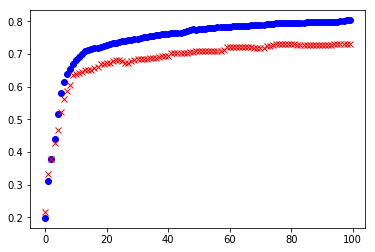

In [31]:
# Notice that accuracy flattens out
# blue
print(train_acc[-1])
# red
print(test_acc[-1])

# Plot the accuracy curves
plt.plot(train_acc, 'bo')
plt.plot(test_acc, 'rx')

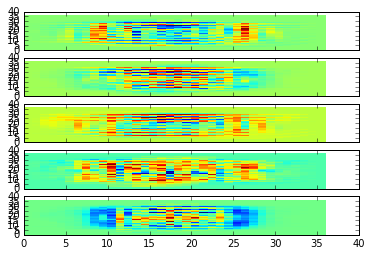

In [22]:
# Look at a subplot of the weights for each font
f, plts = plt.subplots(5, sharex=True)
for i in range(5):
    plts[i].pcolor(W.eval()[:,i].reshape([36,36]))

In [27]:
sess.close()